#Ejemplo

In [5]:
!pip install matplotlib
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached scipy-1.16.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl (8.6 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 26.9 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


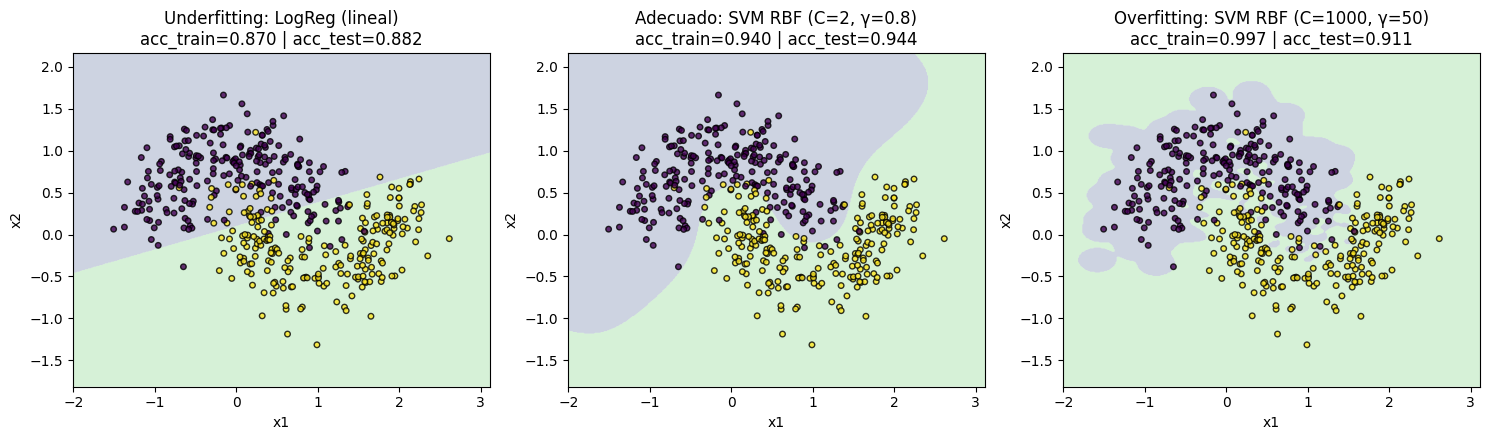

In [6]:
# === Clasificación en 2D para visualizar fronteras (make_moons) ===
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Datos
X, y = make_moons(n_samples=1500, noise=0.25, random_state=RANDOM_STATE)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

# Helper para plotear fronteras
def plot_decision_boundary(ax, model, X, y, title):
    # malla
    x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
    y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25, levels=np.arange(-0.5,2), antialiased=True)
    # puntos
    ax.scatter(X[:,0], X[:,1], c=y, s=16, edgecolor="k", alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

# Modelos: under / adecuado / over
pipe_under = Pipeline([("sc", StandardScaler()),
                       ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])

pipe_good  = Pipeline([("sc", StandardScaler()),
                       ("clf", SVC(kernel="rbf", C=2.0, gamma=0.8, random_state=RANDOM_STATE))])

pipe_over  = Pipeline([("sc", StandardScaler()),
                       ("clf", SVC(kernel="rbf", C=1000.0, gamma=50.0, random_state=RANDOM_STATE))])

models = [("Underfitting: LogReg (lineal)", pipe_under),
          ("Adecuado: SVM RBF (C=2, γ=0.8)", pipe_good),
          ("Overfitting: SVM RBF (C=1000, γ=50)", pipe_over)]

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, (name, mdl) in zip(axes, models):
    mdl.fit(Xtr, ytr)
    yhat_tr = mdl.predict(Xtr)
    yhat_te = mdl.predict(Xte)
    acc_tr = accuracy_score(ytr, yhat_tr)
    acc_te = accuracy_score(yte, yhat_te)
    plot_decision_boundary(ax, mdl, Xte, yte,
                           f"{name}\nacc_train={acc_tr:.3f} | acc_test={acc_te:.3f}")
plt.tight_layout()
plt.show()

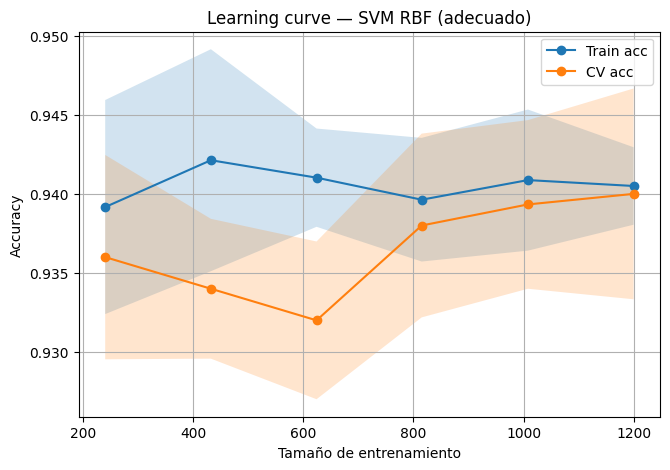

In [7]:
# Curva de aprendizaje del modelo "adecuado"
train_sizes = np.linspace(0.2, 1.0, 6)

train_sizes_abs, train_scores, val_scores = learning_curve(
    pipe_good, X, y,
    train_sizes=train_sizes,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True,
    random_state=RANDOM_STATE
)

tr_mean = train_scores.mean(axis=1)
tr_std  = train_scores.std(axis=1)
va_mean = val_scores.mean(axis=1)
va_std  = val_scores.std(axis=1)

plt.figure(figsize=(7.5, 5))
plt.plot(train_sizes_abs, tr_mean, marker="o", label="Train acc")
plt.fill_between(train_sizes_abs, tr_mean - tr_std, tr_mean + tr_std, alpha=0.2)
plt.plot(train_sizes_abs, va_mean, marker="o", label="CV acc")
plt.fill_between(train_sizes_abs, va_mean - va_std, va_mean + va_std, alpha=0.2)
plt.xlabel("Tamaño de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Learning curve — SVM RBF (adecuado)")
plt.legend()
plt.grid(True)
plt.show()


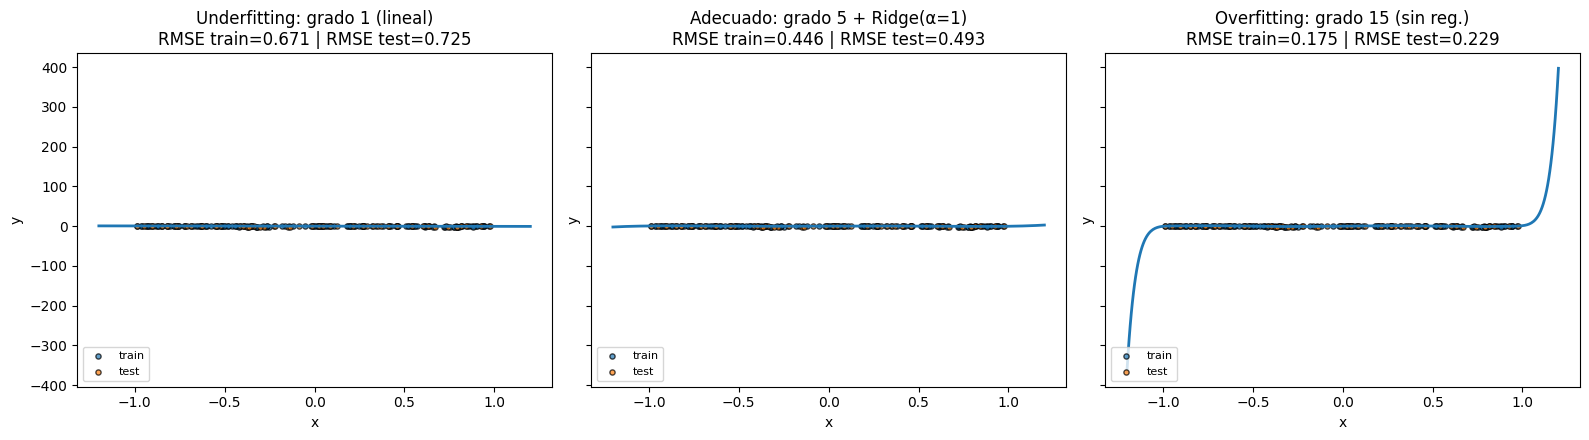

In [11]:
# === Regresión en 1D para ver under/just/over claramente ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
rng = np.random.RandomState(RANDOM_STATE)

# Datos sintéticos: y = sin(2πx) + ruido
n = 200
X = rng.uniform(-1.0, 1.0, size=(n, 1))
y = np.sin(2 * np.pi * X[:,0]) + rng.normal(0, 0.2, size=n)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

def eval_and_plot(ax, pipe, deg_name):
    pipe.fit(Xtr, ytr)
    yhat_tr = pipe.predict(Xtr)
    yhat_te = pipe.predict(Xte)
    rmse_tr = np.sqrt(mean_squared_error(ytr, yhat_tr))
    rmse_te = np.sqrt(mean_squared_error(yte, yhat_te))
    # plot datos + curva
    xs = np.linspace(-1.2, 1.2, 400).reshape(-1,1)
    ys = pipe.predict(xs)
    ax.scatter(Xtr[:,0], ytr, s=14, alpha=0.7, edgecolor="k", label="train")
    ax.scatter(Xte[:,0], yte, s=14, alpha=0.7, edgecolor="k", label="test")
    ax.plot(xs[:,0], ys, lw=2)
    ax.set_title(f"{deg_name}\nRMSE train={rmse_tr:.3f} | RMSE test={rmse_te:.3f}")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.legend(loc="lower left", fontsize=8)

# Modelos:
# Underfitting: polinomio grado 1 (lineal)
under = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("sc", StandardScaler()),
    ("lin", LinearRegression())
])

# Adecuado: grado 5 con ligera regularización (Ridge)
good = Pipeline([
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("sc", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

# Overfitting: grado 15 sin regularización
over = Pipeline([
    ("poly", PolynomialFeatures(degree=15, include_bias=False)),
    ("sc", StandardScaler()),
    ("lin", LinearRegression())
])

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)
eval_and_plot(axes[0], under, "Underfitting: grado 1 (lineal)")
eval_and_plot(axes[1], good,  "Adecuado: grado 5 + Ridge(α=1)")
eval_and_plot(axes[2], over,  "Overfitting: grado 15 (sin reg.)")
plt.tight_layout(); plt.show()


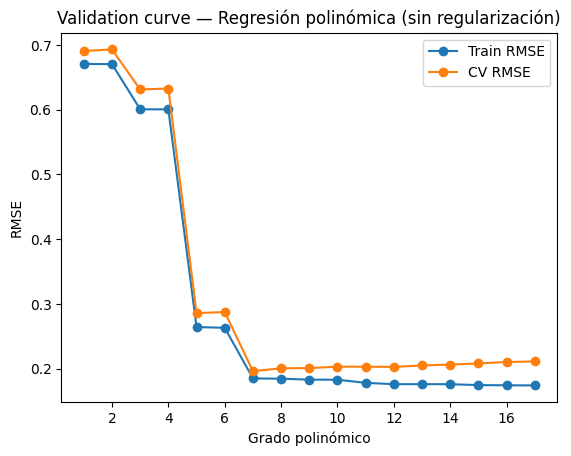

In [12]:
from sklearn.model_selection import cross_val_score

degrees = range(1, 18)
cv_rmse = []
tr_rmse = []

for d in degrees:
    pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("sc", StandardScaler()),
        ("lin", LinearRegression())
    ])
    # CV en todo el dataset (mayor estabilidad)
    scores = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    cv_rmse.append(np.sqrt(-scores.mean()))
    # error de entrenamiento
    pipe.fit(Xtr, ytr)
    tr_rmse.append(np.sqrt(mean_squared_error(ytr, pipe.predict(Xtr))))

plt.plot(degrees, tr_rmse, marker="o", label="Train RMSE")
plt.plot(degrees, cv_rmse, marker="o", label="CV RMSE")
plt.xlabel("Grado polinómico"); plt.ylabel("RMSE")
plt.title("Validation curve — Regresión polinómica (sin regularización)")
plt.legend(); plt.show()


# Otro ejemplo

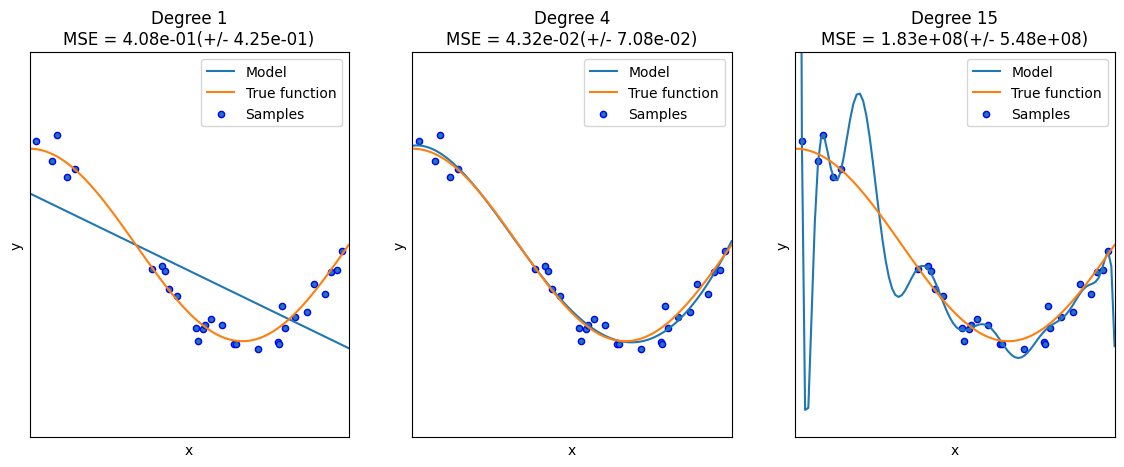

In [13]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

#Ejercicio

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (7.5, 5.5)
plt.rcParams["axes.grid"] = True

def plot_decision_boundary_2d(model, X, y, title="", ax=None, h=0.02):
    """Frontera de decisión para X (n,2)."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25, levels=np.arange(-0.5, y.max()+1.5), antialiased=True)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=22, edgecolor="k", alpha=0.90)
    ax.set_title(title)
    ax.set_xlabel("Feature 1"); ax.set_ylabel("Feature 2")
    return ax

def quick_report(clf, Xtr, ytr, Xte, yte, name=""):
    clf.fit(Xtr, ytr)
    acc_tr = accuracy_score(ytr, clf.predict(Xtr))
    acc_te = accuracy_score(yte, clf.predict(Xte))
    print(f"{name:35s}  acc_train={acc_tr:.3f} | acc_test={acc_te:.3f}")
    return acc_tr, acc_te


In [15]:
# Carga un dataset de https://scikit-learn.org/stable/datasets/toy_dataset.html y elige 2 features para visualizar en 2D
data =
X = data.data[:, [,]]      # feature 1, feature 2
y = data.target
feat_names = np.array(data.feature_names)[[, ]]

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=, random_state=RANDOM_STATE, stratify=y)

print("Shapes:", Xtr.shape, Xte.shape)
print("Features usadas:", feat_names)


SyntaxError: invalid syntax (1916019278.py, line 2)

In [ ]:
plt.scatter(Xtr[:,0], Xtr[:,1], c=ytr, s=24, edgecolor="k")
plt.xlabel(feat_names[0]); plt.ylabel(feat_names[1])
plt.title("dataset — Train (2 features)"); plt.show()

In [ ]:
# Underfitting: modelo lineal (Logistic Regression)
under = Pipeline([
    ("sc", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, multi_class="auto", random_state=RANDOM_STATE))
])

# Adecuado: SVM RBF moderado
good = Pipeline([
    ("sc", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=2.0, gamma=0.5, random_state=RANDOM_STATE))
])

# Overfitting: SVM RBF muy agresivo
over = Pipeline([
    ("sc", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=1000.0, gamma=50.0, random_state=RANDOM_STATE))
])

print("== Resultados (train/test) ==")
quick_report(under, Xtr, ytr, Xte, yte, "Underfitting: LogisticRegression")
quick_report(good,  Xtr, ytr, Xte, yte, "Adecuado: SVM RBF (C=2, γ=0.5)")
quick_report(over,  Xtr, ytr, Xte, yte, "Overfitting: SVM RBF (C=1000, γ=50)")


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)

for ax, (name, clf) in zip(
    axes,
    [("Underfitting (LogReg)", under), ("Adecuado (SVM RBF)", good), ("Overfitting (SVM RBF)", over)]
):
    clf.fit(Xtr, ytr)
    plot_decision_boundary_2d(clf, Xte, yte, title=name, ax=ax)
    ax.set_xlabel(feat_names[0]); ax.set_ylabel(feat_names[1])

plt.tight_layout(); plt.show()

# Matriz de confusión del modelo adecuado (opcional)
good.fit(Xtr, ytr)
ConfusionMatrixDisplay.from_predictions(yte, good.predict(Xte), cmap="Blues")
plt.title("dataset — Matriz de confusión (modelo adecuado)")
plt.show()


In [ ]:
gammas = np.logspace(-3, 2, 12)
pipe_base = Pipeline([("sc", StandardScaler()),
                      ("clf", SVC(kernel="rbf", C=2.0, random_state=RANDOM_STATE))])

train_scores, val_scores = validation_curve(
    pipe_base, Xtr, ytr,
    param_name="clf__gamma",
    param_range=gammas,
    cv=5, scoring="accuracy", n_jobs=-1
)

tr_mean, tr_std = train_scores.mean(axis=1), train_scores.std(axis=1)
va_mean, va_std = val_scores.mean(axis=1), val_scores.std(axis=1)

plt.plot(gammas, tr_mean, marker="o", label="Train acc")
plt.fill_between(gammas, tr_mean-tr_std, tr_mean+tr_std, alpha=0.2)
plt.plot(gammas, va_mean, marker="o", label="CV acc")
plt.fill_between(gammas, va_mean-va_std, va_mean+va_std, alpha=0.2)
plt.xscale("log"); plt.xlabel("gamma"); plt.ylabel("Accuracy")
plt.title("Validation curve — SVM RBF (C=2.0)")
plt.legend(); plt.show()


In [ ]:
# PCA a 2D para graficar pero entrenamos con TODAS las features
data_full = load_iris()
X_full = data_full.data
y_full = data_full.target
feat_all = data_full.feature_names

XtrF, XteF, ytrF, yteF = train_test_split(X_full, y_full, test_size=0.30,
                                          random_state=RANDOM_STATE, stratify=y_full)

# Entrena un modelo "adecuado"
good_full = Pipeline([
    ("sc", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=2.0, gamma=0.5, random_state=RANDOM_STATE))
]).fit(XtrF, ytrF)

# Proyecta para visualizar
pca = PCA(n_components=2, random_state=RANDOM_STATE).fit(XtrF)
Xte_proj = pca.transform(XteF)

# Frontera en el espacio PCA (ojo: el clasificador corre en el espacio original)
# Para sombrear la región, necesitamos predecir sobre una malla en PCA y mapear de vuelta
# Aproximación: graficamos sólo los puntos proyectados + etiquetas; esto evita errores de mapeo inverso.
plt.scatter(Xte_proj[:,0], Xte_proj[:,1], c=yteF, s=26, edgecolor="k")
plt.title("dataset — Test proyectado con PCA (2D)\n(clasificador entrenado en 4D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
acc = accuracy_score(yteF, good_full.predict(XteF))
plt.annotate(f"Test accuracy: {acc:.3f}", xy=(0.02, 0.02), xycoords="axes fraction")
plt.show()


1. Cambia el par de features usado ([0,1], [1,2], etc.) y observa cómo cambia la separabilidad.

2. Ajusta C y gamma del SVM para ver transiciones under → adecuado → over.

3. Prueba k-NN (KNeighborsClassifier) variando n_neighbors.

4. Sustituye a otro dataset y repite el flujo (usa PCA para visualizar).